## combine data as cube like object

multi_index: [year, month, day] # dimension 1
multi_column_index: [Borough, locationID] # dimension 2
value for each cube: [pickups, dropoffs, trip_distance]

In [1]:
from analysis import gen_cube
import pandas as pd
taxi_facts = pd.read_csv('data/clean/df_taxi_facts.csv')
covid_facts = pd.read_csv('data/clean/covid.csv')
weather_facts = pd.read_csv('data/clean/weather.csv')

cov_facts = taxi_facts.merge(covid_facts[['CID', 'case_count']])
c_pickup = gen_cube(taxi_facts, 'pickups', 'sum')
c_dropoffs = gen_cube(taxi_facts, 'dropoffs', 'sum')
c_distances = gen_cube(taxi_facts, 'trip_distance', 'mean')
c_cov_cases = gen_cube(cov_facts, 'case_count', 'sum')

In [2]:
# pickups corellation to covid cases

sum_of_pickups = c_pickup.stack().reset_index().groupby(['year', 'month', 'day']).sum().drop(columns=['undefined', 'level_3']).sum(axis=1).rename('pickups').fillna(0)
sum_of_dropoffs = c_dropoffs.stack().reset_index().groupby(['year', 'month', 'day']).sum().drop(columns=['undefined', 'level_3']).sum(axis=1).rename('dropoffs').fillna(0)

In [3]:
df = weather_facts.copy()
calendar = pd.read_csv('data/clean/calendar.csv')
df = df.merge(calendar[['dateID', 'year', 'month', 'day']], how='left', on='dateID')
df = df.set_index(['year', 'month', 'day'])
weather = df.loc[:,['PRCP', 'TMAX', 'TMIN']]

In [4]:
weather.head()

PRCP  TMAX  TMIN
year month day                  
2018 1     1    0.00  18.0   7.0
           2    0.00  26.0  13.0
           3    0.00  28.0  12.0
           4    0.49  29.0  19.0
           5    0.00  19.0   9.0

In [5]:
df = pd.concat([weather, c_cov_cases, sum_of_pickups, sum_of_dropoffs, c_distances], axis=1).dropna(subset=['pickups', 'dropoffs']).fillna(0)

In [6]:
df.corr()

,PRCP,TMAX,TMIN,case_count,pickups,dropoffs,trip_distance
PRCP,1.000000,0.017896,0.081506,-0.029992,-0.058317,-0.058653,-0.020174
TMAX,0.017896,1.000000,0.947264,-0.331359,-0.105321,-0.106164,0.298264
TMIN,0.081506,0.947264,1.000000,-0.305253,-0.120853,-0.121719,0.313614
case_count,-0.029992,-0.331359,-0.305253,1.000000,-0.004312,-0.004112,-0.037963
pickups,-0.058317,-0.105321,-0.120853,-0.004312,1.000000,0.999990,0.339153
dropoffs,-0.058653,-0.106164,-0.121719,-0.004112,0.999990,1.000000,0.338673
trip_distance,-0.020174,0.298264,0.313614,-0.037963,0.339153,0.338673,1.000000


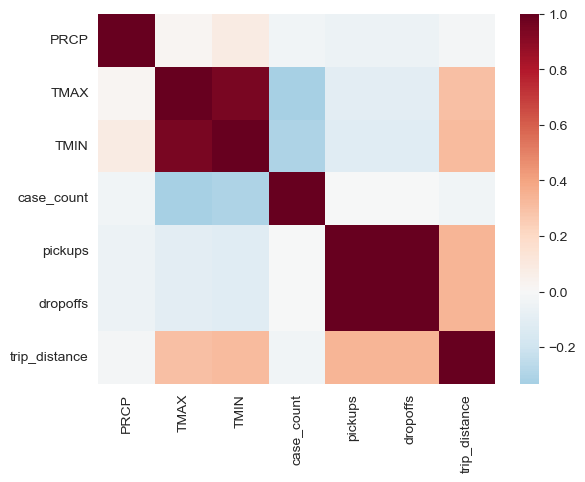

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

cmap = mpl.cm.RdBu_r
import pandas as pd
# create some random data; replace that by your actual dataset

# plot heatmap
ax = sns.heatmap(df.corr(), cmap=cmap, center=0)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('corellation.png', dpi=100)
plt.show()

In [8]:
df.groupby(level=[0,1], axis=0).mean()

PRCP       TMAX       TMIN    case_count        pickups  \
year month                                                                
2020 2      0.000000  37.000000  26.000000      3.000000  250558.000000   
     3      0.121290  53.967742  38.935484   6192.774194  111517.032258   
     4      0.109667  55.900000  41.266667  10514.666667   11697.033333   
     5      0.042903  67.064516  49.322581   2750.032258   16673.032258   
     6      0.105333  80.033333  62.866667   1077.700000   25455.800000   
     7      0.166452  86.387097  72.193548    947.032258   33879.580645   
     8      0.090968  83.064516  69.451613    720.580645   41046.096774   
     9      0.095333  75.866667  60.900000   1109.500000   54095.233333   
     10     0.160645  64.870968  51.483871   1637.709677   63589.870968   
     11     0.155000  59.366667  42.400000   4476.300000   59202.266667   
     12     0.114194  44.677419  32.225806   9463.258065   54270.000000   
2021 1      0.073548  41.096774  28.419355  13225.516129   51255.064516   
     2      0.170357  38.285714  28.035714   9126.428571   54864.142857   
     3      0.099355  52.709677  35.193548   8845.451613   69544.354839   
     4      0.089333  60.533333  43.333333   5398.400000   80544.466667   
     5      0.145806  70.419355  52.096774   1312.645161   88809.548387   
     6      0.052333  79.800000  63.033333    526.500000  102635.633333   
     7      0.190323  82.967742  68.580645   1822.258065   98503.645161   
     8      0.238065  83.354839  70.483871   4464.000000   97496.225806   
     9      0.151667  77.966667  63.500000   3909.500000  107382.800000   
     10     0.140645  69.903226  56.161290   2446.645161  120648.870968   
     11     0.022333  54.200000  38.366667   3197.800000  124712.700000   
     12     0.054839  49.290323  37.451613  48029.967742  115293.838710   
2022 1      0.140968  38.032258  22.580645  36481.129032   88326.387097   
     2      0.110000  44.214286  27.035714   2518.785714  116519.464286   
     3      0.084516  51.064516  35.612903   2140.838710  126720.548387   
     4      0.103333  58.533333  43.366667   4892.033333  130433.500000   

                 dropoffs  trip_distance  
year month                                
2020 2      249927.000000       6.752974  
     3      111251.709677       5.192663  
     4       11653.033333       6.783296  
     5       16569.064516      19.013937  
     6       25378.133333      17.805338  
     7       33796.225806      29.320822  
     8       40931.000000      22.548276  
     9       54287.166667       7.914819  
     10      63826.580645      12.609790  
     11      59356.600000      16.168041  
     12      54440.290323      13.000030  
2021 1       51405.903226      16.671025  
     2       55164.678571       8.524465  
     3       69787.032258      10.351895  
     4       80686.566667      24.037649  
     5       88877.903226      50.689750  
     6      102633.333333      70.822903  
     7       98433.645161      69.930799  
     8       97463.838710      87.994466  
     9      107460.566667      72.418903  
     10     120717.419355      59.746527  
     11     124669.300000      72.988782  
     12     115260.258065      65.659979  
2022 1       88318.451613      17.967046  
     2      116531.964286      24.400712  
     3      126785.580645      17.864287  
     4      130603.966667      18.353055

In [9]:
df = df.groupby(level=[0,1], axis=0).mean()
normalized_df=(df-df.mean())/df.std()
normalized_df.index = [normalized_df.index.get_level_values(0), normalized_df.index.map('{0[0]}/{0[1]}'.format)]
normalized_df = normalized_df.reset_index().rename(columns={'level_1':'date'}).drop(columns=['year'])

In [10]:
normalized_df

,date,PRCP,TMAX,TMIN,case_count,pickups,dropoffs,trip_distance
0,2020/2,-2.117029,-1.543732,-1.338780,-0.637973,3.408714,3.401660,-0.943557
1,2020/3,0.171665,-0.474718,-0.501271,-0.068265,0.545533,0.540666,-1.003495
2,2020/4,-0.047668,-0.352981,-0.350339,0.329523,-1.509996,-1.514143,-0.942393
3,2020/5,-1.307464,0.350414,0.171242,-0.385135,-1.407528,-1.412721,-0.472568
4,2020/6,-0.129436,1.167484,1.048155,-0.539057,-1.226670,-1.230982,-0.518995
5,2020/7,1.023839,1.567789,1.652024,-0.551084,-1.053205,-1.057309,-0.076643
6,2020/8,-0.400508,1.358457,1.474498,-0.571926,-0.905629,-0.910112,-0.336801
7,2020/9,-0.318131,0.904973,0.920823,-0.536130,-0.636917,-0.634563,-0.898927
8,2020/10,0.914274,0.212214,0.311175,-0.487514,-0.441400,-0.437756,-0.718575
9,2020/11,0.807752,-0.134571,-0.276961,-0.226249,-0.531751,-0.529976,-0.581890


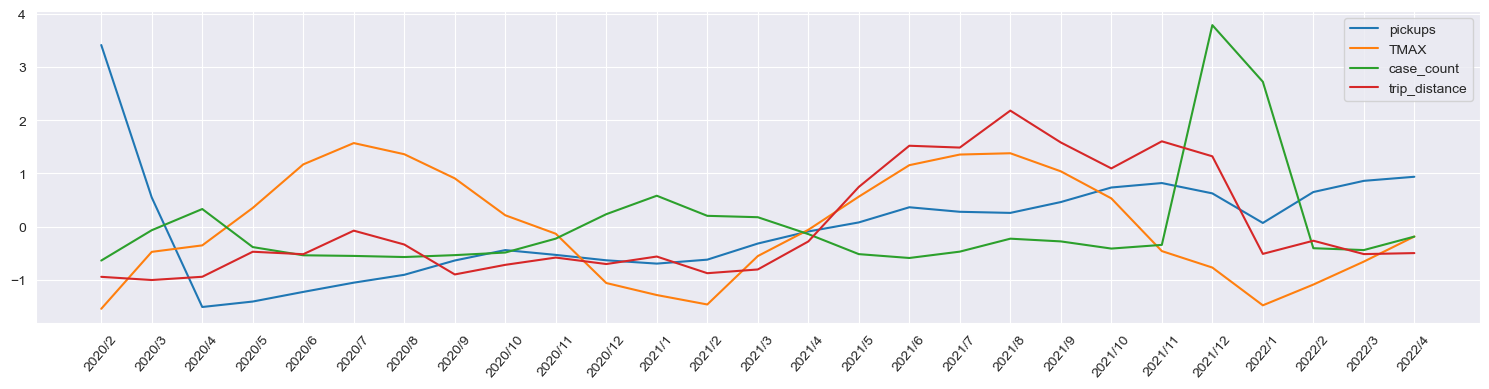

In [18]:
plt.figure(figsize=(15,4))

# multiple line plots
plt.plot('date', 'pickups', data=normalized_df)
plt.plot('date', 'TMAX', data=normalized_df)
plt.plot('date', 'case_count', data=normalized_df)
plt.plot('date', 'trip_distance', data=normalized_df)

plt.xticks(rotation=50)
# show legend
plt.legend()
plt.tight_layout()
# show graph
plt.savefig('linegraph.png', dpi=100)
plt.show()

In [20]:
df

PRCP       TMAX       TMIN    case_count        pickups  \
year month                                                                
2020 2      0.000000  37.000000  26.000000      3.000000  250558.000000   
     3      0.121290  53.967742  38.935484   6192.774194  111517.032258   
     4      0.109667  55.900000  41.266667  10514.666667   11697.033333   
     5      0.042903  67.064516  49.322581   2750.032258   16673.032258   
     6      0.105333  80.033333  62.866667   1077.700000   25455.800000   
     7      0.166452  86.387097  72.193548    947.032258   33879.580645   
     8      0.090968  83.064516  69.451613    720.580645   41046.096774   
     9      0.095333  75.866667  60.900000   1109.500000   54095.233333   
     10     0.160645  64.870968  51.483871   1637.709677   63589.870968   
     11     0.155000  59.366667  42.400000   4476.300000   59202.266667   
     12     0.114194  44.677419  32.225806   9463.258065   54270.000000   
2021 1      0.073548  41.096774  28.419355  13225.516129   51255.064516   
     2      0.170357  38.285714  28.035714   9126.428571   54864.142857   
     3      0.099355  52.709677  35.193548   8845.451613   69544.354839   
     4      0.089333  60.533333  43.333333   5398.400000   80544.466667   
     5      0.145806  70.419355  52.096774   1312.645161   88809.548387   
     6      0.052333  79.800000  63.033333    526.500000  102635.633333   
     7      0.190323  82.967742  68.580645   1822.258065   98503.645161   
     8      0.238065  83.354839  70.483871   4464.000000   97496.225806   
     9      0.151667  77.966667  63.500000   3909.500000  107382.800000   
     10     0.140645  69.903226  56.161290   2446.645161  120648.870968   
     11     0.022333  54.200000  38.366667   3197.800000  124712.700000   
     12     0.054839  49.290323  37.451613  48029.967742  115293.838710   
2022 1      0.140968  38.032258  22.580645  36481.129032   88326.387097   
     2      0.110000  44.214286  27.035714   2518.785714  116519.464286   
     3      0.084516  51.064516  35.612903   2140.838710  126720.548387   
     4      0.103333  58.533333  43.366667   4892.033333  130433.500000   

                 dropoffs  trip_distance  
year month                                
2020 2      249927.000000       6.752974  
     3      111251.709677       5.192663  
     4       11653.033333       6.783296  
     5       16569.064516      19.013937  
     6       25378.133333      17.805338  
     7       33796.225806      29.320822  
     8       40931.000000      22.548276  
     9       54287.166667       7.914819  
     10      63826.580645      12.609790  
     11      59356.600000      16.168041  
     12      54440.290323      13.000030  
2021 1       51405.903226      16.671025  
     2       55164.678571       8.524465  
     3       69787.032258      10.351895  
     4       80686.566667      24.037649  
     5       88877.903226      50.689750  
     6      102633.333333      70.822903  
     7       98433.645161      69.930799  
     8       97463.838710      87.994466  
     9      107460.566667      72.418903  
     10     120717.419355      59.746527  
     11     124669.300000      72.988782  
     12     115260.258065      65.659979  
2022 1       88318.451613      17.967046  
     2      116531.964286      24.400712  
     3      126785.580645      17.864287  
     4      130603.966667      18.353055

In [ ]:
import matplotlib as plt
ax = c_cov_cases.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(12, 7), layout=(2, 3))
plt.tight_layout()

In [ ]:
df = c_distances.groupby(level=0, axis=1).sum()
ax = df.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(12, 7), layout=(2, 3))
plt.tight_layout()

In [ ]:
dfp = df.pivot_table(index='year', values=df.columns, aggfunc='mean')

dfp.plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3, 3))
plt.tight_layout()